In [1]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 100
from skimage.transform import resize
import torchaudio.transforms as T
import torch
import json

nfft = 2048
win_length = 2048 # int(16000 * 0.025)
n_mels = 64
hop_length = int(16000 * 0.01)
fmin, fmax = 50, 350
melspectrogram = T.MelSpectrogram(
    sample_rate=16000, win_length=win_length, n_mels=n_mels, n_fft=nfft, hop_length=hop_length, f_min=fmin, f_max=fmax,
)

mfcc_transform = T.MFCC(
    sample_rate=16000, n_mfcc=32, melkwargs={'n_fft': nfft, 'n_mels': n_mels, 'hop_length': hop_length}
)

/home/tjy/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def spectro(y: np.ndarray, start: float, dur: float, sr=16000):
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=64, n_fft=nfft, hop_length=hop_length, fmin=fmin, fmax=fmax
    )
    S = librosa.power_to_db(S)

    # crop to the start and the end of a phone
    end = start + dur
    s, e = librosa.time_to_frames([start, end], sr=sr, hop_length=hop_length)
    s = np.max(s, 0)
    e = np.max(e, 0)

    return S[:, s:e + 1]


def spectro1(y, start: float, dur: float, sr=16000):
    y = torch.as_tensor(y, dtype=torch.float32)
    S = melspectrogram(y)
    S = 10 * torch.log10(S)

    # crop to the start and the end of a phone
    end = start + dur
    s, e = librosa.time_to_frames([start, end], sr=sr, hop_length=hop_length)
    s = np.max(s, 0)
    e = np.max(e, 0)

    return S[:, s:e + 1].numpy()

def mfcc(y, start: float, dur: float, sr=16000):
    y = torch.as_tensor(y, dtype=torch.float32)
    S = mfcc_transform(y)

    # crop to the start and the end of a phone
    end = start + dur
    s, e = librosa.time_to_frames([start, end], sr=sr, hop_length=hop_length)
    s = np.max(s, 0)
    e = np.max(e, 0)

    return S[:, s:e + 1].numpy()

def postprocess(S):
    S = S[::-1, :]
    S = resize(
        S, output_shape=(225, 225),
        anti_aliasing=False, preserve_range=True, clip=False,
        mode='constant', cval=0, order=0,
    )
    return S

# MFCC

```python
start, dur = 0.53, 0.24
# start, dur = 0.1, 0.1

y, _ = librosa.load('tmp/IC0001W0010_sp11.wav', sr=16000)
S = mfcc(y, start/1.1, dur/1.1)
# S = postprocess(S)
plt.imshow(S, cmap='magma')
plt.axis('off')
plt.colorbar()
```

# Mel-Spectrogram

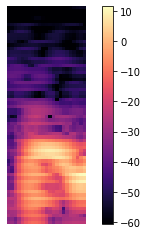

In [3]:
start, dur = 0.53, 0.24
# start, dur = 0.1, 0.1

y, _ = librosa.load('tmp/IC0001W0010_sp11.wav', sr=16000)
S = spectro(y, start/1.1, dur/1.1)
# S = postprocess(S)
plt.imshow(S, cmap='magma')
plt.axis('off')
plt.colorbar()

(-0.5, 224.5, 224.5, -0.5)

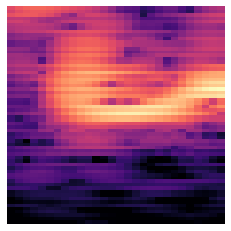

In [4]:
y, _ = librosa.load('tmp/IC0001W0010_sp09.wav', sr=16000)
S = spectro(y, start/0.9, dur/0.9)
S = postprocess(S)
plt.imshow(S, cmap='magma')
plt.axis('off')

# Visualizations

In [5]:
utt2tones = json.load(open('utt2tones.json'))
utts = list(utt2tones.keys())

WAV_DIR = '/NASdata/AudioData/AISHELL-ASR-SSB/SPEECHDATA/'

def get_wav_path(utt: str):
    spk = utt[:7]
    return os.path.join(WAV_DIR, spk, f'{utt}.wav')

import random
# utt = random.choice(list(utt2tones.keys()))
utt = 'SSB19020141'

## Visualize wav

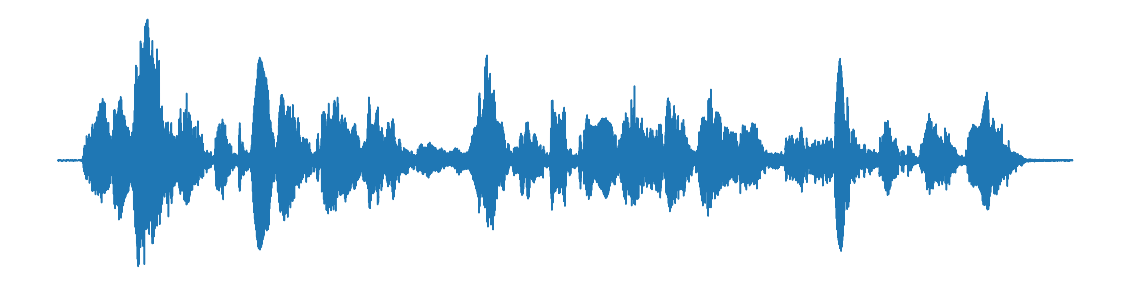

In [6]:
fig_width = 1000
fig_height = 225

sr = 16000

fig, ax = plt.subplots(figsize=(20, 5))

y, _ = librosa.load(get_wav_path(utt), sr=sr)
plt.plot(y)
plt.axis('off')
plt.savefig(f'{utt}.png')

## Visualize alignment

x	0	0.030s to 0.240s
iao	1	0.105s to 0.345s
f	0	0.240s to 0.450s
ei	4	0.345s to 0.555s
zh	0	0.450s to 0.675s
e	3	0.555s to 0.795s
g	0	0.675s to 0.900s
ou	4	0.795s to 0.990s
w	0	0.900s to 1.065s
u	4	0.990s to 1.170s
x	0	1.065s to 1.290s
i	2	1.170s to 1.380s
g	0	1.290s to 1.470s
uan	4	1.380s to 1.560s
d	0	1.470s to 1.635s
e	5	1.560s to 1.725s
zh	0	1.635s to 1.830s
uan	3	1.725s to 1.935s
b	0	1.830s to 2.145s
ian	4	1.935s to 2.310s


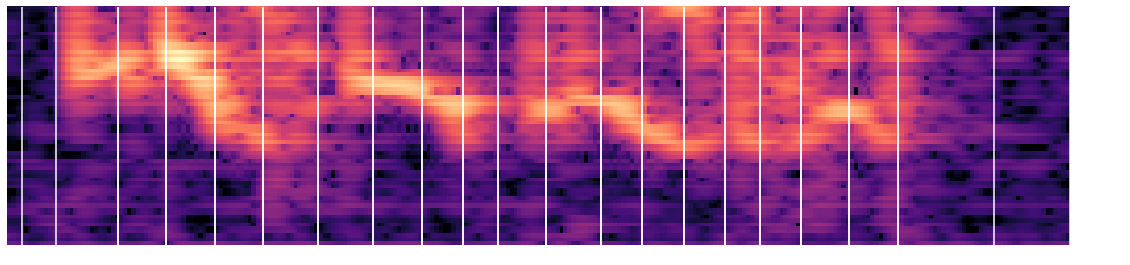

In [7]:
# utt = 'SSB17810334'
utt = 'SSB07020180'

data = utt2tones[utt]

timestamps = []
for tone, phone, start, dur in data:
    print(f'{phone}\t{tone}\t{start:.3f}s to {start + dur:.3f}s')
    timestamps += [start, start + dur]
timestamps = np.asarray(timestamps)

min_sec = np.min(timestamps)
max_sec = np.max(timestamps)

fig_width = 1000
fig_height = 225

sr = 16000
# timestamps = librosa.time_to_frames(timestamps, sr=sr, hop_length=hop_length)
timestamps = fig_width * timestamps / max_sec

fig, ax = plt.subplots(figsize=(20, 5))

y, _ = librosa.load(get_wav_path(utt), sr=sr)
S = spectro(y, 0, 1000, sr=sr)
S = S[::-1, :]
# S = mfcc(y, 0, 1000, sr=sr)

S = resize(
    S, output_shape=(fig_height, fig_width),
    anti_aliasing=False, preserve_range=True, clip=False,
    mode='constant', cval=0, order=0,
)
plt.imshow(S, cmap='magma')
plt.axis('off')
ax.vlines(timestamps, 0, fig_height, colors='white')
plt.savefig(f'{utt}.png')

2 er 0.465 0.19499999999999998
utt: SSB05390092
3 a 0.66 0.18
4 ei 1.14 0.225000000000000038
utt: SSB05390092
3 ou 1.365 0.19499999999999998
5 e 1.725 0.28599999999999998
-------------------------
4 ie 2.085 0.225999998 0.25555999999999998
utt: SSB18100272
3 iao 2.31 0.24000000000000002
4 ai 2.55 0.3
-------------------------
4 er 0.39 0.195
utt: SSB19180478
3 ian 0.585 0.405
1 an 2.0549999999999997 0.435
-------------------------


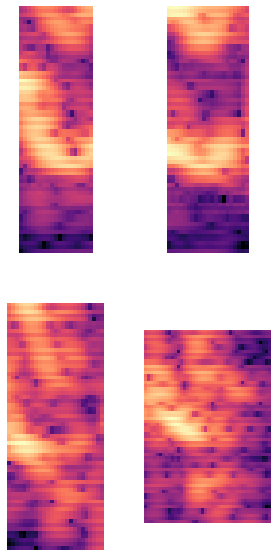

In [8]:
tone3s = []
N = 4

random.shuffle(utts)
for utt in utts:
    data = utt2tones[utt]
    if len(tone3s) >= N:
        break
    for tone, phone, start, dur in data:
        if tone == 0:
            continue
        end = '\r'
        if len(tone3s) < N and tone == 3:
            print()
            print(f'utt: {utt}')
            tone3s.append([utt, start, dur])
            end = '\n'
        print(tone, phone, start, dur, end=end)
    print()
    print('-' * 25)

fig, axs = plt.subplots(2, 2, figsize=(5, 10))
axs = axs.flat

for i, (utt, start, dur) in enumerate(tone3s):
    y, _ = librosa.load(get_wav_path(utt), sr=sr)
    S = spectro(y, start, dur, sr=sr)
    S = S[::-1, :]
    axs[i].imshow(S, cmap='magma')
    axs[i].axis('off')

plt.savefig(f'tone3s.png')